<a href="https://colab.research.google.com/github/dcolinmorgan/MIMB/blob/main/PRS_MMoll.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os,gc,glob
# import s3fs
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from psutil import *
import scipy.io
from scipy.stats import zscore
import datetime
from sklearn import metrics
import traceback
import joblib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
conv=pd.read_csv('drive/MyDrive/PRS_MMoll/conv.txt',sep=' ',names=['gene','sid'])
# data=pd.read_csv('drive/MyDrive/PRS_MMoll/fulldata2.txt',sep='\t',index_col=0)
pheno=pd.read_csv('drive/MyDrive/PRS_MMoll/phenoall.txt',sep=' ')


In [25]:
data2=data.merge(conv,on=['sid'])
data2.index=data2.gene
del data2['sid'] 
del data2['gene']

In [322]:
##switched to mutually exclusive groupings

In [298]:
# pheno2=pheno[['sid','trs','prs_composite']]
P1T0=data2[pheno2.sid[(pheno['prs_composite']>0.5) & (pheno['trs']<-0.5)]]
P0T0=data2[pheno2.sid[(pheno['prs_composite']<-0.5) & (pheno['trs']<-0.5)]]

P1T1=data2[pheno2.sid[(pheno['prs_composite']>0.5) & (pheno['trs']>0.5)]]
P0T1=data2[pheno2.sid[(pheno['prs_composite']<-0.5) & (pheno['trs']>0.5)]]

In [299]:
P1T0.to_csv('drive/MyDrive/PRS_MMoll/PRS1.txt',sep='\t',header=False,index=True)
P0T0.to_csv('drive/MyDrive/PRS_MMoll/PRS0.txt',sep='\t',header=False,index=True)
P1T1.to_csv('drive/MyDrive/PRS_MMoll/TRS1.txt',sep='\t',header=False,index=True)
P0T1.to_csv('drive/MyDrive/PRS_MMoll/TRS0.txt',sep='\t',header=False,index=True)

In [300]:
[P1T0.shape[1],P0T0.shape[1],P1T1.shape[1],P0T1.shape[1]]

[192, 269, 230, 203]

In [301]:
# !git clone --single-branch --branch milipede_beta https://github.com/dcolinmorgan/netZooPy.git
# os.chdir('netZooPy')
# !pip install -e ./

In [302]:
# import netZooPy
# from netZooPy.panda import Panda
# from netZooPy.lioness import Lioness
# from netZooPy.milipede import Milipede ## just commented out to use reload above
# os.chdir('..')

In [303]:

# ppi=pd.read_csv('https://granddb.s3.amazonaws.com/optPANDA/ppi/ppi_complete.txt',sep='\t',header=0)

# med_mot=pd.read_csv('https://granddb.s3.amazonaws.com/optPANDA/motifs/Hugo_motifCellLine.txt',sep='\t',header=0)

In [304]:
# !wget https://granddb.s3.amazonaws.com/optPANDA/ppi/ppi_complete.txt
# !wget https://granddb.s3.amazonaws.com/optPANDA/motifs/Hugo_motifCellLine.txt

In [ ]:
panda_objP1=netZooPy.panda.Panda(expression_file='drive/MyDrive/PRS_MMoll/PRS1.txt',
                      # methylation_file='0m_motif.txt',
                      motif_file='Hugo_motifCellLine.txt',
                      ppi_file='ppi_complete.txt',
    computing='gpu',modeProcess='intersection',save_memory=False,save_tmp=False,precision='single',keep_expression_matrix=False)#,save_dir='drive/My Drive/Colab Notebooks/LCL_mili_partial/')#,start=0,end='agg',


# milipeed_objA.save_milipeed_results(file='LCL_mili_full/LCL_mili_partial_'+date+'.txt')
# panda_objP1.save_panda_results('drive/MyDrive/PRS_MMoll/PRS1.txt')
panda_objP1.export_panda_results.to_csv('drive/MyDrive/PRS_MMoll/PRS1.txt')

In [ ]:
panda_objP0=netZooPy.panda.Panda(expression_file='drive/MyDrive/PRS_MMoll/PRS0.txt',
                      # methylation_file='0m_motif.txt',
                      motif_file='Hugo_motifCellLine.txt',
                      ppi_file='ppi_complete.txt',
    computing='gpu',modeProcess='intersection',save_memory=False,save_tmp=False,precision='single',keep_expression_matrix=False)#,save_dir='drive/My Drive/Colab Notebooks/LCL_mili_partial/')#,start=0,end='agg',
    # save_fmt='npy',map_file='netZooPy/tests/milipeed/MotifPrior_CGmap.txt')

# milipeed_objA.save_milipeed_results(file='LCL_mili_full/LCL_mili_partial_'+date+'.txt')
# panda_objP0.save_panda_results('drive/MyDrive/PRS_MMoll/PRS0.txt')
panda_objP0.export_panda_results.to_csv('drive/MyDrive/PRS_MMoll/PRS0.txt')

In [307]:
P1=pd.read_csv('drive/MyDrive/PRS_MMoll/PRS1.txt',sep=',',index_col=0)
P0=pd.read_csv('drive/MyDrive/PRS_MMoll/PRS0.txt',sep=',',index_col=0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [308]:
TFsum_4=P1.groupby(['tf']).agg({'force':sum})
TFsum_2=P0.groupby(['tf']).agg({'force':sum})
TFsum_2['force']=zscore(TFsum_2['force'])
TFsum_4['force']=zscore(TFsum_4['force']) ##reduces range from 2500 to 4

geneSum_4=P1.groupby(['gene']).agg({'force':sum})
geneSum_2=P0.groupby(['gene']).agg({'force':sum})
geneSum_4['force']=zscore(geneSum_4['force'])
geneSum_2['force']=zscore(geneSum_2['force'])

mmm=TFsum_4.merge(TFsum_2, left_on=['tf'], right_on=['tf'])
mmmm=geneSum_4.merge(geneSum_2, left_on=['gene'], right_on=['gene'])

# del [[P1, P0]]
# gc.collect()
P1=pd.DataFrame()
P0=pd.DataFrame()
Panda_FcontFULL=pd.DataFrame()
Panda_FcontFULL=pd.DataFrame()


mmm['diff']=mmm.force_x-mmm.force_y
mmm = mmm.sort_values(by ='diff' )


mmmm['diff']=mmmm.force_x-mmmm.force_y
mmmm = mmmm.sort_values(by ='diff' )
mmm.to_csv('drive/My Drive/PRS_MMoll/TF_zscore_PRS.txt',sep='\t')
mmmm.to_csv('drive/My Drive/PRS_MMoll/gene_zscore_PRS.txt',sep='\t')

In [ ]:
panda_objT1=netZooPy.panda.Panda(expression_file='drive/MyDrive/PRS_MMoll/TRS1.txt',
                      # methylation_file='0m_motif.txt',
                      motif_file='Hugo_motifCellLine.txt',
                      ppi_file='ppi_complete.txt',
    computing='gpu',modeProcess='intersection',save_memory=False,save_tmp=False,precision='single',keep_expression_matrix=False)#,save_dir='drive/My Drive/Colab Notebooks/LCL_mili_partial/')#,start=0,end='agg',
    # save_fmt='npy',map_file='netZooPy/tests/milipeed/MotifPrior_CGmap.txt')

# milipeed_objA.save_milipeed_results(file='LCL_mili_full/LCL_mili_partial_'+date+'.txt')

panda_objT1.export_panda_results.to_csv('drive/MyDrive/PRS_MMoll/TRS1.txt')

In [ ]:
panda_objT0=netZooPy.panda.Panda(expression_file='drive/MyDrive/PRS_MMoll/TRS0.txt',
                      # methylation_file='0m_motif.txt',
                      motif_file='Hugo_motifCellLine.txt',
                      ppi_file='ppi_complete.txt',
    computing='gpu',modeProcess='intersection',save_memory=False,save_tmp=False,precision='single',keep_expression_matrix=False)#,save_dir='drive/My Drive/Colab Notebooks/LCL_mili_partial/')#,start=0,end='agg',
    # save_fmt='npy',map_file='netZooPy/tests/milipeed/MotifPrior_CGmap.txt')

# milipeed_objA.save_milipeed_results(file='LCL_mili_full/LCL_mili_partial_'+date+'.txt')

panda_objT0.export_panda_results.to_csv('drive/MyDrive/PRS_MMoll/TRS0.txt')

In [311]:
T1=pd.read_csv('drive/MyDrive/PRS_MMoll/TRS1.txt',sep=',',index_col=0)
T0=pd.read_csv('drive/MyDrive/PRS_MMoll/TRS0.txt',sep=',',index_col=0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [312]:
TFsum_3=T1.groupby(['tf']).agg({'force':sum})
TFsum_1=T0.groupby(['tf']).agg({'force':sum})
TFsum_1['force']=zscore(TFsum_1['force'])
TFsum_3['force']=zscore(TFsum_3['force']) ##reduces range from 1500 to 3

geneSum_3=T1.groupby(['gene']).agg({'force':sum})
geneSum_1=T0.groupby(['gene']).agg({'force':sum})
geneSum_3['force']=zscore(geneSum_3['force'])
geneSum_1['force']=zscore(geneSum_1['force'])

mmm=TFsum_3.merge(TFsum_1, left_on=['tf'], right_on=['tf'])
mmmm=geneSum_3.merge(geneSum_1, left_on=['gene'], right_on=['gene'])

# del [[T1, T0]]
# gc.collect()
T1=pd.DataFrame()
T0=pd.DataFrame()
# Panda_FcontFULL=pd.DataFrame()
# Panda_FcontFULL=pd.DataFrame()


mmm['diff']=mmm.force_x-mmm.force_y
mmm = mmm.sort_values(by ='diff' )


mmmm['diff']=mmmm.force_x-mmmm.force_y
mmmm = mmmm.sort_values(by ='diff' )
mmm.to_csv('drive/My Drive/PRS_MMoll/TF_zscore_TPR.txt',sep='\t')
mmmm.to_csv('drive/My Drive/PRS_MMoll/gene_zscore_TPR.txt',sep='\t')

In [313]:
pp=pd.read_csv('drive/My Drive/PRS_MMoll/TF_zscore_PRS.txt',sep='\t',header=0)
ppp=pd.read_csv('drive/My Drive/PRS_MMoll/gene_zscore_PRS.txt',sep='\t',header=0)
tt=pd.read_csv('drive/My Drive/PRS_MMoll/TF_zscore_TPR.txt',sep='\t',header=0)
ttt=pd.read_csv('drive/My Drive/PRS_MMoll/gene_zscore_TPR.txt',sep='\t',header=0)

tf_diffB=pp.merge(tt,on='tf')
tf_diffB.columns=['TF','prs1','prs0','prs_diff','trs1','trs0','trs_diff']
tf_diffB.to_csv('drive/My Drive/PRS_MMoll/TF_PRS-TPS_diff.txt',sep='\t',index=0)


gene_diffB=ppp.merge(ttt,on='gene')
gene_diffB.columns=['gene','prs1','prs0','prs_diff','trs1','trs0','trs_diff']
gene_diffB.to_csv('drive/My Drive/PRS_MMoll/gene_PRS-TPS_diff.txt',sep='\t',index=0)


In [314]:
gene_diffB

,gene,prs1,prs0,prs_diff,trs1,trs0,trs_diff
0,FAM161B,-1.497206,-0.666567,-0.830639,-1.223802,-1.351331,0.127529
1,SDR42E1,-0.651921,0.131581,-0.783502,-0.347875,-1.031611,0.683736
2,CPT1A,0.392555,1.157771,-0.765215,0.680443,0.640788,0.039656
3,DSC2,-0.582163,0.167542,-0.749705,0.085596,-0.050784,0.136380
4,OTUD7A,-0.542989,0.206330,-0.749319,-0.183898,-0.131217,-0.052681
...,...,...,...,...,...,...,...
10071,ZNF418,0.002159,-0.711816,0.713976,-0.334497,-0.857469,0.522972
10072,PSMD5-AS1,-0.047857,-0.813682,0.765825,0.219596,-0.049180,0.268776
10073,INPP5B,1.095575,0.304480,0.791095,0.735146,0.858013,-0.122867
10074,CDKN2B,-0.029730,-1.014703,0.984974,-0.830742,-0.749772,-0.080970


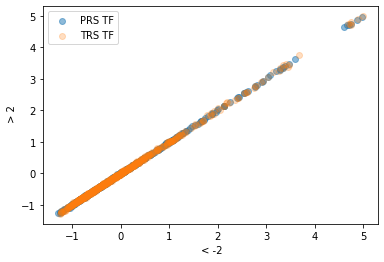

In [315]:
p1=plt.scatter(tf_diffB['prs1'],tf_diffB['prs0'],alpha=.5)
p2=plt.scatter(tf_diffB['trs1'],tf_diffB['trs0'],alpha=.25)
plt.ylabel(' > 2')
plt.xlabel(' < -2')
plt.legend((p1, p2),('PRS TF','TRS TF'))

In [316]:
tf_diffB['ab_diff']=tf_diffB['prs_diff']-tf_diffB['trs_diff']
tf_diffB.sort_values(by='ab_diff')

,TF,prs1,prs0,prs_diff,trs1,trs0,trs_diff,ab_diff
1,OSR1,-0.762198,-0.717661,-0.044537,-0.718714,-0.768004,0.049290,-0.093828
0,ZSCAN16,-0.074970,-0.028415,-0.046555,-0.007441,-0.053148,0.045707,-0.092262
17,NRF1,-0.239032,-0.215259,-0.023773,-0.176066,-0.232461,0.056395,-0.080168
81,GABPA,0.423717,0.434910,-0.011193,0.474760,0.424395,0.050364,-0.061557
69,TFCP2L1,-1.193602,-1.181536,-0.012066,-1.146478,-1.190816,0.044338,-0.056404
...,...,...,...,...,...,...,...,...
326,ZNF274,0.479776,0.478472,0.001304,0.453402,0.497573,-0.044171,0.045475
602,NAIF1,-1.224560,-1.240183,0.015623,-1.232077,-1.202172,-0.029905,0.045528
11,ZBTB7B,3.276494,3.305915,-0.029421,3.345199,3.424762,-0.079562,0.050142
601,NR1I2,0.350092,0.334642,0.015450,0.312848,0.349615,-0.036767,0.052217


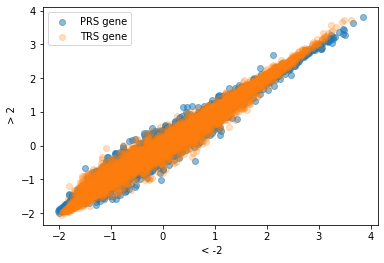

In [317]:
p1=plt.scatter(gene_diffB['prs1'],gene_diffB['prs0'],alpha=.5)
p2=plt.scatter(gene_diffB['trs1'],gene_diffB['trs0'],alpha=.25)
plt.ylabel(' > 2')
plt.xlabel(' < -2')
plt.legend((p1, p2),('PRS gene','TRS gene'))

In [318]:
gene_diffB['ab_diff']=gene_diffB['prs_diff']-gene_diffB['trs_diff']
gene_diffB.sort_values(by='ab_diff')

,gene,prs1,prs0,prs_diff,trs1,trs0,trs_diff,ab_diff
1,SDR42E1,-0.651921,0.131581,-0.783502,-0.347875,-1.031611,0.683736,-1.467238
23,ZEB1-AS1,-1.097811,-0.493759,-0.604052,-0.209783,-0.961462,0.751678,-1.355730
12,LIX1L,-0.302591,0.377782,-0.680373,0.404390,-0.257370,0.661760,-1.342133
25,LINC00852,-0.141728,0.445567,-0.587295,0.641673,-0.022860,0.664533,-1.251828
9,RP1-29C18.8,-0.205155,0.509531,-0.714686,0.617001,0.151839,0.465162,-1.179847
...,...,...,...,...,...,...,...,...
10074,CDKN2B,-0.029730,-1.014703,0.984974,-0.830742,-0.749772,-0.080970,1.065944
10040,P2RY14,-0.213910,-0.758335,0.544426,-0.753673,-0.224183,-0.529490,1.073915
10008,HRH4,-0.126613,-0.618780,0.492167,-0.757807,-0.130290,-0.627517,1.119684
10057,ALDH1A1,0.221957,-0.415333,0.637290,-0.469165,0.021139,-0.490305,1.127595


(array([ 4., 12.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  6.]),
 array([-1.46723826, -1.18723729, -0.90723632, -0.62723534, -0.34723437,
        -0.06723339,  0.21276758,  0.49276855,  0.77276953,  1.0527705 ,
         1.33277148]),
 <a list of 10 Patch objects>)

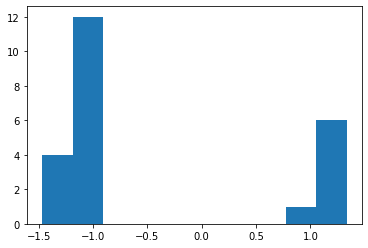

In [319]:
plt.hist(gene_diffB.ab_diff[np.abs(gene_diffB.ab_diff)>1],bins=10)

In [321]:
gene_diffB.gene[np.abs(gene_diffB.ab_diff)>1]

1              SDR42E1
5               OTUD7B
6        RP11-379H18.1
7                GATA3
9          RP1-29C18.8
12               LIX1L
13              ZSWIM5
23            ZEB1-AS1
25           LINC00852
30                SKA3
32             TIMM23B
42           DPY19L1P1
50             NDUFA10
88             ZKSCAN7
121              TERF2
218       RP11-57H14.4
10008             HRH4
10036           KLHL12
10040           P2RY14
10055           ZNF641
10057          ALDH1A1
10074           CDKN2B
10075             EMR1
Name: gene, dtype: object